### <div align="center"><b><h3>Spam Email Detector - Personal Project</h3></b></div>
#### Introduction
In this project, I challenge myself to learn the basics of machine learning.

<b>The problem:</b> Spam—we all receive it and know how annoying it can be. What if I could write a script that labels emails as spam if certain patterns are detected?

<b>Solution:</b> Using a database of emails labeled as spam or ham, I will train a machine-learning model to accurately classify emails as potential spam.

Let's see if it really was this easy:

#### First Steps - Data Loading
Firstly, I needed to find a database of pre-categorized emails. Fortunately, this was straightforward thanks to free databases available on the web. I used this one, kindly uploaded by M. Wiechmann, who slightly modified the original resource created by V. Metsis, I. Androutsopoulos, and G. Paliouras.

Let's see what we have in there. As shown in the graph below, the distribution of ham and spam emails is fairly balanced in this database.

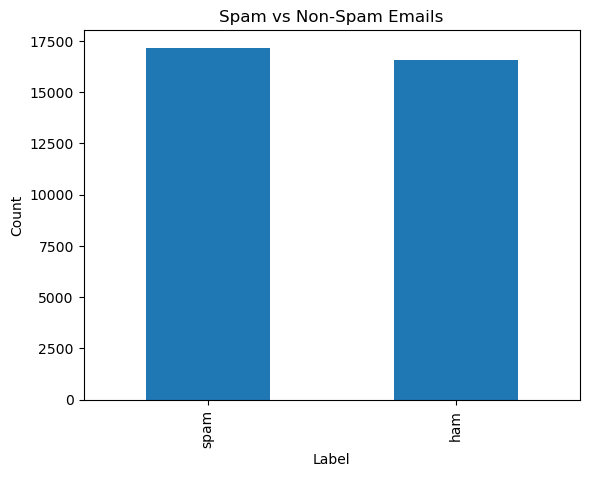

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('enron_spam_data.csv')  # Load the dataset

# Visualize the distribution of spam vs. non-spam emails
data['Spam/Ham'].value_counts().plot(kind='bar')
plt.title('Spam vs Non-Spam Emails')  # Set the plot title
plt.xlabel('Label')  # X-axis label
plt.ylabel('Count')  # Y-axis label
plt.show()  # Display the plot

#### Data Preparation
I cannot use this data in its current state because it contains many unnecessary columns and the text is not in the right format. During the data preparation process, I:

First stripped the CSV of unnecessary columns and dropped any empty values.

Next, I filtered out punctuation and stopwords—commonly used words that do not contribute to the model’s ability to label emails (like "the" or "and"). This task is heavily facilitated by the NLTK library, which provides easy access to pre-made lists of punctuation and English stopwords.

Near the end, I tokenized each of the values, breaking them down into individual words.

Finally, I assigned the email's subject and contents to X and the Spam/Ham categorization to Y. This way, we can easily train the model later, showing it how input X results in output Y, allowing it to identify any patterns.

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.data.path.append('nltk_data')  # Set NLTK data path

data = data.drop(columns=['Message ID', 'Date'])  # Remove unnecessary columns
data = data.dropna()  # Drop rows with missing values

def preprocess_text(text):
    text = text.lower().strip()  # Lowercase and strip whitespace
    tokens = word_tokenize(text)  # Tokenize text
    stop_words = set(stopwords.words('english'))  # Set of stopwords
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]  # Filter tokens
    return ' '.join(tokens)  # Return cleaned text

# Apply preprocessing to Subject and Message columns
data['cleaned_subject'] = data['Subject'].apply(preprocess_text)
data['cleaned_message'] = data['Message'].apply(preprocess_text)

X = data['cleaned_subject'] + ' ' + data['cleaned_message']  # Combine cleaned text
y = data['Spam/Ham']  # Target variable

Now that the data is pre-processed, I need to vectorize it for the machine-learning algorithm to understand it, converting the values into numerical representations. To do this, I’m using a TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer.

Similarly, the Spam/Ham categorization also needs to be converted to numerical values. I use a Label Encoder, which assigns the value "0" to Spam and "1" to Ham.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()  # Initialize the TF-IDF vectorizer
X = vectorizer.fit_transform(data['cleaned_subject'] + ' ' + data['cleaned_message'])  # Transform the text data

le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Encode labels: "0" for Spam and "1" for Ham

#### Data Splitting
I could use all the data to train the model; however, I would also need a separate set to evaluate its effectiveness. It is common practice to split the data into a training set and a testing set. This way, one dataset is used for training the model, while the other is used to assess its performance.

Splitting the data is straightforward, thanks to a sublibrary in scikit-learn. I simply define the variables and the test size, and appropriate values are automatically assigned.

In this example, I use 90% of the data to train the model and 10% to test it later.

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (90% train, 10% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1)

#### Machine Learning Model Training
For this project, I chose the Multinomial Naive Bayes model, which is a common choice due to its effectiveness in text classification (particularly spam detection), ability to handle high-dimensional data, relatively low training time, and real-time prediction capabilities.

The model works by counting the occurrences of each word in an email and using these counts to calculate the probability that the email is spam or ham, based on patterns learned from the training dataset.

Training the model on the pre-processed data is straightforward. I use the .fit() function from the scikit-learn library.

In [ ]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()  # Initialize the Multinomial Naive Bayes model

model.fit(X_train, y_train)  # Train the model with training data

y_pred = model.predict(X_test)  # Predict outputs for the test data

#### Visualizing How the Model Works
At this point, the model is trained. Although I understand how it works, I wanted to visualize the model's findings. What makes an email more likely to be classified as Spam? And what about Ham?

Using the code below, I create a visualization of the top 10 words indicative of each type of email. It is evident that Spam emails commonly mention money.

In [1]:
# Import necessary libraries for visualization
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_feature_importance(model, vectorizer):
    feature_names = vectorizer.get_feature_names_out()
    log_probs = model.feature_log_prob_
    
    spam_importance = log_probs[1]
    ham_importance = log_probs[0]
    
    top_n = 10
    spam_indices = np.argsort(spam_importance)[-top_n:]
    ham_indices = np.argsort(ham_importance)[-top_n:]

    plt.figure(figsize=(10, 5))
    plt.barh(feature_names[spam_indices], spam_importance[spam_indices], color='red', label='Spam')
    plt.barh(feature_names[ham_indices], ham_importance[ham_indices], color='blue', label='Ham', alpha=0.5)
    plt.xlabel('Log Probability')
    plt.title(f'Top {top_n} Features for Spam and Ham Classification')
    plt.legend()
    plt.show()

plot_feature_importance(model, vectorizer)


NameError: name 'model' is not defined

#### Model testing
Awesome! I've got my model up and running. Now it's time to test it's accurracy. Thankfully in the sklearn library there are many built-in functions that make it a breeze.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)  # Calculate the accuracy of the model
print(f"Accuracy: {accuracy}")

conf_matrix = confusion_matrix(y_test, y_pred)  # Generate the confusion matrix

# Display counts of correct and incorrect predictions for each class
print(f"Spam labeled right/wrong: {conf_matrix[0][0]} / {conf_matrix[0][1]}")
print(f"Ham labeled right/wrong: {conf_matrix[1][0]} / {conf_matrix[1][1]}")

NameError: name 'y_test' is not defined

#### Fine Tuning
Although the model is already trained, it uses default hyperparameters. There is a possibility that we can improve the model's accuracy by tweaking some of these values. One of the most common methods to find optimal hyperparameters is using Randomized Search. This technique randomly samples values from a specified range to identify the best ones.

This process takes some time, as the model needs to be trained and tested repeatedly before reporting the best values.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the hyperparameter distribution
param_distributions = {
    'alpha': np.linspace(0.1, 2.0, 10)  # Range of alpha values for optimization
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, 
                                   n_iter=10, scoring='accuracy', cv=3, verbose=1, random_state=42)

# Fit the model to find the best hyperparameters
random_search.fit(X_train, y_train)

# Output the best parameters found
print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'alpha': 0.1}
Best Cross-validation Score: 0.9889246878775674


Let's evaluate the model's accuracy with the best parameters. As shown below, I managed to achieve slightly better performance using the Randomized Search technique.

In [ ]:
# Get the best model from the randomized search
best_model = random_search.best_estimator_

# Evaluate the test accuracy of the best model
test_accuracy = best_model.score(X_test, y_test)

# Output the test accuracy with the best parameters
print("Test Accuracy with Best Parameters:", test_accuracy)

Accuracy: 0.9855028692237995
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1606
           1       0.99      0.98      0.99      1705

    accuracy                           0.99      3311
   macro avg       0.99      0.99      0.99      3311
weighted avg       0.99      0.99      0.99      3311

[[1586   20]
 [  28 1677]]
Test Accuracy with Best Parameters: 0.988221081244337


#### Manual Testing
Now, I'd like to test the model by composing an email myself and observing how it is labeled. I'll start by defining a function that accomplishes this.

In [ ]:
def predict_email(subject, message):
    # Preprocess the subject and message
    cleaned_subject = preprocess_text(subject)
    cleaned_message = preprocess_text(message)
    
    # Combine cleaned subject and message
    custom_email = cleaned_subject + ' ' + cleaned_message
    
    # Vectorize the combined email text
    custom_email_vectorized = vectorizer.transform([custom_email]).toarray()
    
    # Make a prediction using the best model
    prediction = best_model.predict(custom_email_vectorized)
    
    # Return the label corresponding to the predicted class
    return le.inverse_transform(prediction)[0]

Everything is ready for testing now. Feel free to modify the inputs and explore how it works!

In [ ]:
# Test the email prediction function with a sample subject and message. Try it yourself!
result = predict_email("Buy our latest product!", "We invite you to buy our company's newest product!")

print(f"The email is predicted to be: {result}.")

The email is predicted to be: ham


#### Saving the Model and the Vectorizer
Now that the model is functioning and I've identified the best parameters, I would like to save it. This way, I don't have to undergo resource-intensive training each time I want to utilize its labeling capabilities. This task can be easily accomplished using the joblib library.

I will save both the best model and the vectorizer for easy access later using the code below.

In [ ]:
from joblib import dump

# Save the trained model to a file for future use
dump(best_model, 'spam_detection_best_model.joblib')

# Save the vectorizer to a file for later access
dump(vectorizer, 'vectorizer.joblib')